In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from gensim.models import Word2Vec

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2021)
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

url = './example-question-dataset-master/'



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\uyent\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uyent\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
thoughts_topics = pd.read_csv(url + 'thoughts_topics.csv')
thoughts_topics.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,topic_id
0,0,1.0,0.2685,"people, friend, family, ability, send, access,...",Its easy to use and very heavily adopted by ot...,Easy to Use
1,1,2.0,0.2547,"easily, picture, post, share, weird, recent, f...",Easy access is just about the only thing.,Easy To Access
2,2,1.0,0.2836,"people, friend, family, ability, send, access,...",youtube makes it really easy to see what kind ...,Easy to Use
3,3,3.0,0.2737,"easy, content, post, update, live, block, inst...",Being able to mute/block people. It helps keep...,Show Relevant Contents
4,4,2.0,0.2596,"easily, picture, post, share, weird, recent, f...",Being able to share content,Easy To Access


In [3]:
agreements = pd.read_csv(url + 'agreements.csv')
agreements.head()


,respondent_id,thought_id,label
0,32,7,Disagree
1,37,3,Agree
2,37,1,Disagree
3,37,14,Disagree
4,37,19,Disagree


In [4]:
thoughts = pd.read_csv(url+ 'thoughts.csv')
thoughts.head()

,id,respondent_id,text
0,0,17,It's easy to use and very heavily adopted by o...
1,1,38,Easy access is just about the only thing.
2,2,23,youtube makes it really easy to see what kind ...
3,3,5,Being able to mute/block people. It helps keep...
4,4,25,Being able to share content


In [5]:
thought_topics = thoughts_topics[['Document_No', 'Dominant_Topic', 'topic_id']]
thought_topics = thought_topics.rename(columns={"Document_No": "id", 
                                                "Dominant_Topic": 'topic_id',
                                               "topic_id" : 'topic'})
thought_topics.head()

,id,topic_id,topic
0,0,1.0,Easy to Use
1,1,2.0,Easy To Access
2,2,1.0,Easy to Use
3,3,3.0,Show Relevant Contents
4,4,2.0,Easy To Access


In [6]:
thoughts_final = thoughts.merge(thought_topics, how='left', on='id')
thoughts_final=thoughts_final.drop(['text'], axis=1)
thoughts_final.head()

,id,respondent_id,topic_id,topic
0,0,17,1.0,Easy to Use
1,1,38,2.0,Easy To Access
2,2,23,1.0,Easy to Use
3,3,5,3.0,Show Relevant Contents
4,4,25,2.0,Easy To Access


## Visualize User's Response Frequency Based On Topics

In [7]:
tt_df = thought_topics.groupby('topic').count()
tt_df = tt_df.drop('id',axis =1)


Text(0.5, 1.0, "Value Count of User's Response Based On Topics")

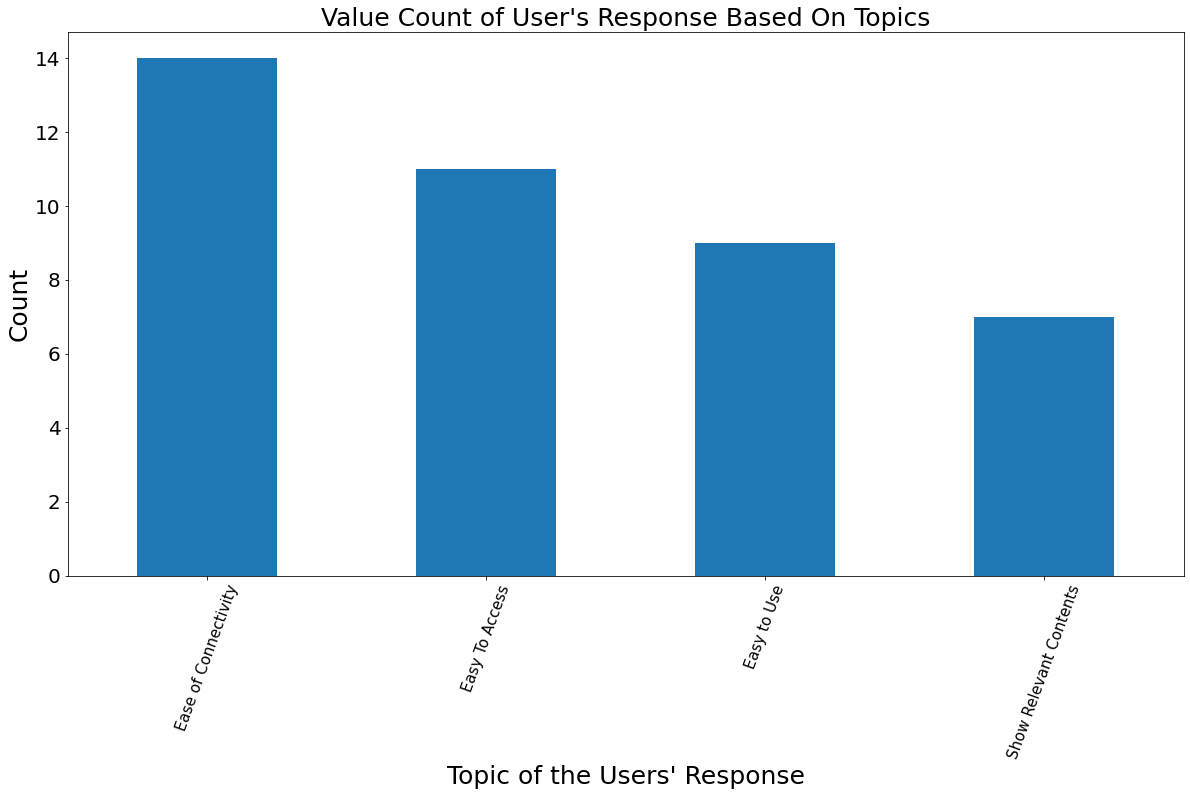

In [8]:
tt_df.plot(kind='bar', figsize=(20,10), legend=False)
plt.xlabel("Topic of the Users' Response", size = 25)
plt.ylabel('Count', size = 25)
plt.xticks(rotation=70, size = 15)
plt.yticks(size = 20)
plt.title("Value Count of User's Response Based On Topics", size =25)


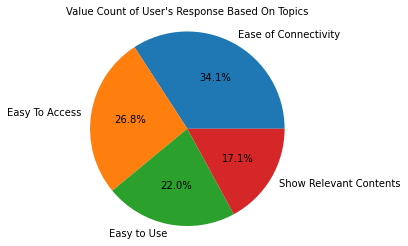

In [9]:
plt.pie(tt_df['topic_id'], labels=tt_df.index,autopct='%1.1f%%',radius = 2.5)
plt.title("Value Count of User's Response Based On Topics", size =10)
plt.axis('equal')
plt.show()

# Merge thoughts dataset with agreeements

In [10]:
# get the new topic for thought id
agree = agreements.merge(thought_topics, left_on='thought_id', right_on='id')
agree

,respondent_id,thought_id,label,id,topic_id,topic
0,32,7,Disagree,7,0.0,Ease of Connectivity
1,1,7,Disagree,7,0.0,Ease of Connectivity
2,38,7,Agree,7,0.0,Ease of Connectivity
3,11,7,Agree,7,0.0,Ease of Connectivity
4,28,7,Disagree,7,0.0,Ease of Connectivity
...,...,...,...,...,...,...
263,10,32,Agree,32,2.0,Easy To Access
264,40,12,Agree,12,1.0,Easy to Use
265,15,12,Agree,12,1.0,Easy to Use
266,33,12,Disagree,12,1.0,Easy to Use


In [11]:
agreements['thought_id'] = agree['topic_id']
agreements

,respondent_id,thought_id,label
0,32,0.0,Disagree
1,37,0.0,Agree
2,37,0.0,Disagree
3,37,0.0,Disagree
4,37,0.0,Disagree
...,...,...,...
263,33,2.0,Agree
264,10,1.0,Agree
265,33,1.0,Agree
266,15,1.0,Disagree


In [12]:
agree_thought = thoughts_final.merge(agreements, how='outer', left_on=['respondent_id'], right_on = ['respondent_id'])
agree_thought = agree_thought.dropna().reset_index(drop=True)
agree_thought

,id,respondent_id,topic_id,topic,thought_id,label
0,0.0,17,1.0,Easy to Use,1.0,Agree
1,0.0,17,1.0,Easy to Use,3.0,Agree
2,0.0,17,1.0,Easy to Use,0.0,Agree
3,0.0,17,1.0,Easy to Use,0.0,Agree
4,1.0,38,2.0,Easy To Access,1.0,Agree
...,...,...,...,...,...,...
261,40.0,8,3.0,Show Relevant Contents,2.0,Disagree
262,40.0,8,3.0,Show Relevant Contents,2.0,Disagree
263,40.0,8,3.0,Show Relevant Contents,0.0,Disagree
264,40.0,8,3.0,Show Relevant Contents,2.0,Agree


## Visualization

### Count on Response with the Same Topics

In [13]:
same_thought = agree_thought[(agree_thought.topic_id == agree_thought.thought_id)].reset_index(drop=True)
same_thought

,id,respondent_id,topic_id,topic,thought_id,label
0,0.0,17,1.0,Easy to Use,1.0,Agree
1,1.0,38,2.0,Easy To Access,2.0,Disagree
2,1.0,38,2.0,Easy To Access,2.0,Disagree
3,1.0,38,2.0,Easy To Access,2.0,Agree
4,4.0,25,2.0,Easy To Access,2.0,Agree
...,...,...,...,...,...,...
82,38.0,19,1.0,Easy to Use,1.0,Disagree
83,39.0,33,1.0,Easy to Use,1.0,Agree
84,39.0,33,1.0,Easy to Use,1.0,Agree
85,40.0,8,3.0,Show Relevant Contents,3.0,Disagree


In [14]:
st_df = same_thought.groupby('topic')['label'].apply(lambda x: (x=='Agree').sum()).reset_index(name='count')

In [15]:
st_df['Disagree'] = same_thought.groupby('topic')['label'].apply(lambda x: (x=='Disagree').sum()).reset_index(name='count')['count']

In [16]:
st_df = st_df.rename(columns={'count':'Agree'})
st_df = st_df.set_index('topic')

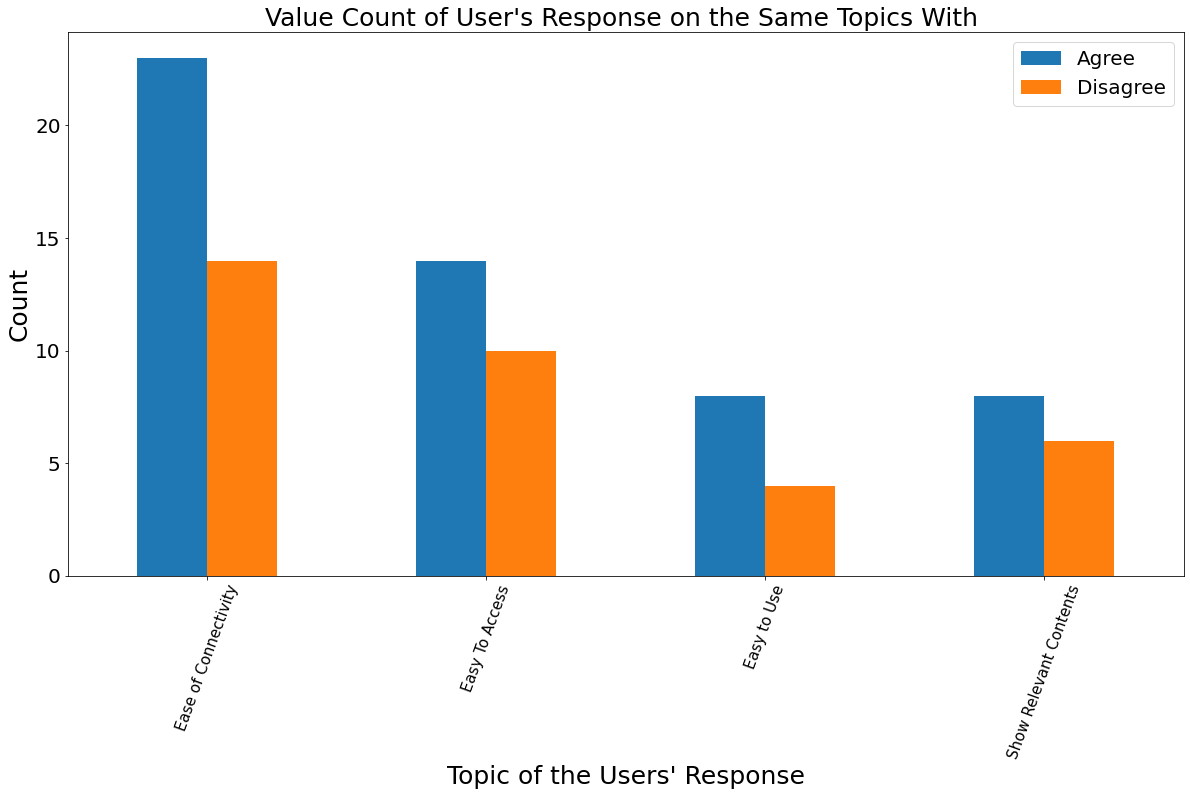

In [17]:
st_df.plot(kind='bar', figsize=(20,10))
plt.xlabel("Topic of the Users' Response", size = 25)
plt.ylabel('Count', size = 25)
plt.xticks(rotation=70, size = 15)
plt.yticks(size = 20)
plt.title("Value Count of User's Response on the Same Topics With ", size =25)
plt.legend(fontsize=20)

### Count on Response with the Different Topics

In [18]:
diff_thought = agree_thought[(agree_thought.topic_id != agree_thought.thought_id)].reset_index(drop=True)
diff_thought

,id,respondent_id,topic_id,topic,thought_id,label
0,0.0,17,1.0,Easy to Use,3.0,Agree
1,0.0,17,1.0,Easy to Use,0.0,Agree
2,0.0,17,1.0,Easy to Use,0.0,Agree
3,1.0,38,2.0,Easy To Access,1.0,Agree
4,1.0,38,2.0,Easy To Access,1.0,Agree
...,...,...,...,...,...,...
174,40.0,8,3.0,Show Relevant Contents,2.0,Disagree
175,40.0,8,3.0,Show Relevant Contents,2.0,Disagree
176,40.0,8,3.0,Show Relevant Contents,0.0,Disagree
177,40.0,8,3.0,Show Relevant Contents,2.0,Agree


In [19]:
dt_df = diff_thought.groupby('topic')['label'].apply(lambda x: (x=='Agree').sum()).reset_index(name='count')
dt_df['Disagree'] =diff_thought.groupby('topic')['label'].apply(lambda x: (x=='Disagree').sum()).reset_index(name='count')['count']

In [20]:
dt_df = dt_df.rename(columns={'count':'Agree'})
dt_df = dt_df.set_index('topic')

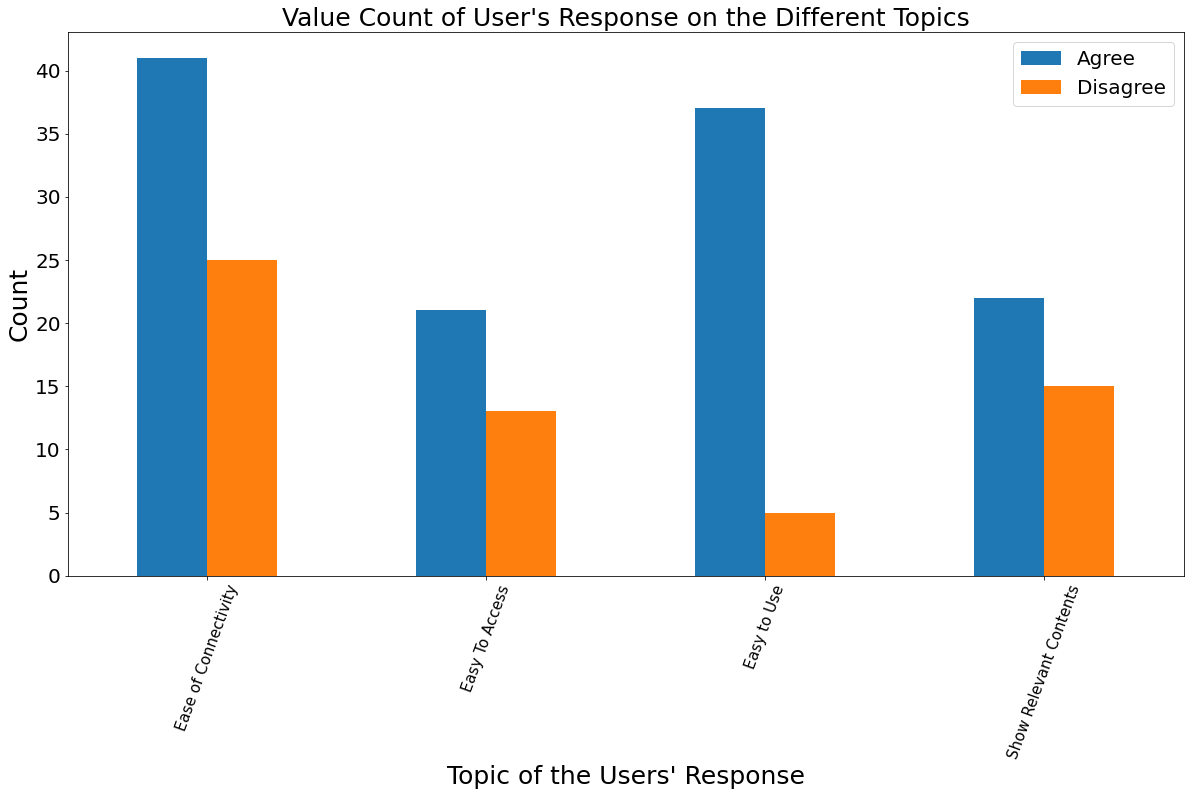

In [21]:
dt_df.plot(kind='bar', figsize=(20,10))
plt.xlabel("Topic of the Users' Response", size = 25)
plt.ylabel('Count', size = 25)
plt.xticks(rotation=70, size = 15)
plt.yticks(size = 20)
plt.title("Value Count of User's Response on the Different Topics", size =25)
plt.legend(fontsize=20)

# Merge Thoughts with Binary Choices

In [22]:
binary_choices = pd.read_csv(url + 'binary_choices.csv')
binary_choices.isnull().sum()
binary_choices


,respondent_id,thought_a_id,thought_b_id,label
0,32,20,14,A
1,29,19,21,A
2,37,6,19,A
3,32,35,5,A
4,37,8,6,B
...,...,...,...,...
142,33,12,29,B
143,33,12,38,B
144,10,38,29,B
145,33,18,5,A


In [23]:
thoughts_final.head()

,id,respondent_id,topic_id,topic
0,0,17,1.0,Easy to Use
1,1,38,2.0,Easy To Access
2,2,23,1.0,Easy to Use
3,3,5,3.0,Show Relevant Contents
4,4,25,2.0,Easy To Access


In [24]:
# get the new topic for thought id
bin_choice_a = binary_choices.merge(thought_topics, left_on='thought_a_id', right_on='id')
bin_choice_b = binary_choices.merge(thought_topics, left_on='thought_b_id', right_on='id')
binary_choices['thought_a_id'] = bin_choice_a['topic_id']
binary_choices['thought_a_topic'] = bin_choice_a['topic']
binary_choices['thought_b_id'] = bin_choice_b['topic_id']
binary_choices['thought_b_topic'] = bin_choice_a['topic']
binary_choices

,respondent_id,thought_a_id,thought_b_id,label,thought_a_topic,thought_b_topic
0,32,0.0,0.0,A,Ease of Connectivity,Ease of Connectivity
1,29,0.0,3.0,A,Ease of Connectivity,Ease of Connectivity
2,37,0.0,3.0,A,Ease of Connectivity,Ease of Connectivity
3,32,0.0,1.0,A,Ease of Connectivity,Ease of Connectivity
4,37,0.0,1.0,B,Ease of Connectivity,Ease of Connectivity
...,...,...,...,...,...,...
142,33,0.0,2.0,B,Ease of Connectivity,Ease of Connectivity
143,33,0.0,0.0,B,Ease of Connectivity,Ease of Connectivity
144,10,2.0,0.0,B,Easy To Access,Easy To Access
145,33,0.0,3.0,A,Ease of Connectivity,Ease of Connectivity


In [25]:
# merge thought with binary choices
bin_thoughts = thoughts_final.merge(binary_choices, how='outer', left_on=['respondent_id'], right_on = ['respondent_id'])
bin_thoughts = bin_thoughts.dropna().reset_index(drop=True)
bin_thoughts

,id,respondent_id,topic_id,topic,thought_a_id,thought_b_id,label,thought_a_topic,thought_b_topic
0,1,38,2.0,Easy To Access,3.0,2.0,B,Show Relevant Contents,Show Relevant Contents
1,1,38,2.0,Easy To Access,3.0,1.0,A,Show Relevant Contents,Show Relevant Contents
2,1,38,2.0,Easy To Access,3.0,2.0,B,Show Relevant Contents,Show Relevant Contents
3,1,38,2.0,Easy To Access,3.0,2.0,A,Show Relevant Contents,Show Relevant Contents
4,1,38,2.0,Easy To Access,2.0,0.0,B,Easy To Access,Easy To Access
...,...,...,...,...,...,...,...,...,...
142,39,33,1.0,Easy to Use,0.0,2.0,B,Ease of Connectivity,Ease of Connectivity
143,39,33,1.0,Easy to Use,0.0,0.0,B,Ease of Connectivity,Ease of Connectivity
144,39,33,1.0,Easy to Use,0.0,3.0,A,Ease of Connectivity,Ease of Connectivity
145,40,8,3.0,Show Relevant Contents,0.0,3.0,B,Ease of Connectivity,Ease of Connectivity


## Visualization

### Users with Consistent Responses

In [26]:
same_bin = bin_thoughts[((bin_thoughts.topic_id == bin_thoughts.thought_a_id) & (bin_thoughts.label == 'A'))
             | ((bin_thoughts.topic_id == bin_thoughts.thought_b_id) & (bin_thoughts.label == 'B'))]

same_bin = same_bin.reset_index(drop=True)
same_bin

,id,respondent_id,topic_id,topic,thought_a_id,thought_b_id,label,thought_a_topic,thought_b_topic
0,1,38,2.0,Easy To Access,3.0,2.0,B,Show Relevant Contents,Show Relevant Contents
1,1,38,2.0,Easy To Access,3.0,2.0,B,Show Relevant Contents,Show Relevant Contents
2,7,37,0.0,Ease of Connectivity,0.0,3.0,A,Ease of Connectivity,Ease of Connectivity
3,8,0,2.0,Easy To Access,2.0,1.0,A,Easy To Access,Easy To Access
4,8,0,2.0,Easy To Access,2.0,1.0,A,Easy To Access,Easy To Access
5,9,27,0.0,Ease of Connectivity,2.0,0.0,B,Easy To Access,Easy To Access
6,9,27,0.0,Ease of Connectivity,0.0,2.0,A,Ease of Connectivity,Ease of Connectivity
7,12,13,1.0,Easy to Use,3.0,1.0,B,Show Relevant Contents,Show Relevant Contents
8,12,13,1.0,Easy to Use,3.0,1.0,B,Show Relevant Contents,Show Relevant Contents
9,13,41,0.0,Ease of Connectivity,1.0,0.0,B,Easy to Use,Easy to Use


In [27]:
sb_df = same_bin.groupby('topic')['label'].apply(lambda x: (x=='A').sum()).reset_index(name='count')
sb_df['B'] = same_bin.groupby('topic')['label'].apply(lambda x: (x=='B').sum()).reset_index(name='count')['count']
sb_df

,topic,count,B
0,Ease of Connectivity,13,12
1,Easy To Access,5,5
2,Easy to Use,2,6
3,Show Relevant Contents,1,1


In [28]:
sb_df = sb_df.rename(columns={'count':'A'})
sb_df = sb_df.set_index('topic')

In [29]:
sum_column = sb_df["A"] + sb_df["B"]
sb_df['sum'] = sum_column
sb_df

,A,B,sum
topic,,,
Ease of Connectivity,13,12,25
Easy To Access,5,5,10
Easy to Use,2,6,8
Show Relevant Contents,1,1,2


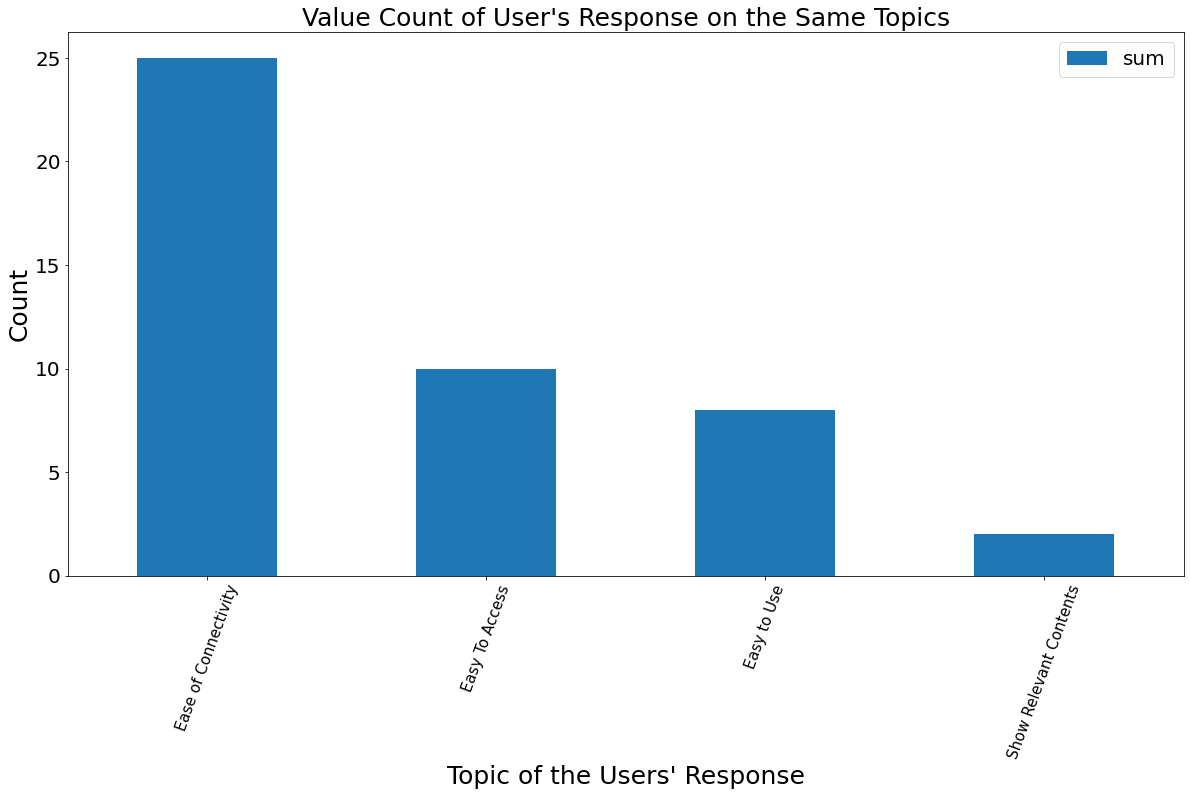

In [30]:
sb_df['sum'].plot(kind='bar', figsize=(20,10))
plt.xlabel("Topic of the Users' Response", size = 25)
plt.ylabel('Count', size = 25)
plt.xticks(rotation=70, size = 15)
plt.yticks(size = 20)
plt.title("Value Count of User's Response on the Same Topics", size =25)
plt.legend(fontsize=20)

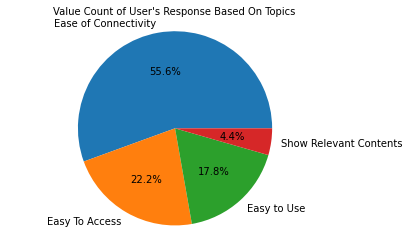

In [31]:
plt.pie(sb_df['sum'], labels=sb_df.index,autopct='%1.1f%%',radius = 2.5)
plt.title("Value Count of User's Response Based On Topics", size =10)
plt.axis('equal')
plt.show()

### Users with Different Responses

In [32]:
diff_bin = bin_thoughts[~(((bin_thoughts.topic_id == bin_thoughts.thought_a_id) & (bin_thoughts.label == 'A'))
             | ((bin_thoughts.topic_id == bin_thoughts.thought_b_id) & (bin_thoughts.label == 'B')))]

diff_bin = diff_bin.reset_index(drop=True)
diff_bin

,id,respondent_id,topic_id,topic,thought_a_id,thought_b_id,label,thought_a_topic,thought_b_topic
0,1,38,2.0,Easy To Access,3.0,1.0,A,Show Relevant Contents,Show Relevant Contents
1,1,38,2.0,Easy To Access,3.0,2.0,A,Show Relevant Contents,Show Relevant Contents
2,1,38,2.0,Easy To Access,2.0,0.0,B,Easy To Access,Easy To Access
3,5,34,0.0,Ease of Connectivity,2.0,2.0,B,Easy To Access,Easy To Access
4,5,34,0.0,Ease of Connectivity,2.0,1.0,B,Easy To Access,Easy To Access
...,...,...,...,...,...,...,...,...,...
97,39,33,1.0,Easy to Use,2.0,2.0,B,Easy To Access,Easy To Access
98,39,33,1.0,Easy to Use,0.0,2.0,B,Ease of Connectivity,Ease of Connectivity
99,39,33,1.0,Easy to Use,0.0,0.0,B,Ease of Connectivity,Ease of Connectivity
100,39,33,1.0,Easy to Use,0.0,3.0,A,Ease of Connectivity,Ease of Connectivity


In [33]:
db_df = diff_bin.groupby('topic')['label'].apply(lambda x: (x=='A').sum()).reset_index(name='count')
db_df['B'] = diff_bin.groupby('topic')['label'].apply(lambda x: (x=='B').sum()).reset_index(name='count')['count']
db_df['Neither'] = diff_bin.groupby('topic')['label'].apply(lambda x: (x=='Neither').sum()).reset_index(name='count')['count']
db_df

,topic,count,B,Neither
0,Ease of Connectivity,11,17,0
1,Easy To Access,15,11,0
2,Easy to Use,22,13,2
3,Show Relevant Contents,4,7,0
